In [ ]:
!pip install asyncpraw pandas numpy textblob matplotlib seaborn scikit-learn nest_asyncio
import asyncpraw
import pandas as pd
import numpy as np
import random
from datetime import datetime
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import asyncio
import nest_asyncio



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 6.4 MB/s eta 0:00:00


In [ ]:
# Apply nest_asyncio for Colab compatibility
nest_asyncio.apply()

# ======================
# REDDIT SCRAPER CONFIG
# ======================
REDDIT_CREDS = {
      "client_id": "Client_ID_Here",
      "client_secret": "Client_Secret_Here",
      "user_agent": "User_Agent_Name_Here"
}

CITIES = {
    "jaipur": [
        "JaipurTravel", "PinkCity", "RajasthanTourism", "AmberFort",
        "JaipurFood", "HawaMahal", "JaipurHeritage", "JaipurPalace"
    ],
    "delhi": [
        "DelhiTourism", "IndiaGate", "DelhiFood", "QutubMinar",
        "OldDelhi", "DelhiHeritage", "DelhiMarkets", "HumayunsTomb"
    ],
    "udaipur": [
        "UdaipurTravel", "CityOfLakes", "LakePichola", "JagMandir",
        "Rajasthan", "UdaipurPalace", "MonsoonPalace", "UdaipurViews"
    ],
    "kolkata": [
        "KolkataTravel", "HowrahBridge", "VictoriaMemorial", "KolkataFood",
        "DurgaPuja", "BengaliCulture", "KolkataTrams", "ParkStreet"
    ],
    "bhubaneswar": [
        "BhubaneswarTour", "OdishaTravel", "LingarajaTemple", "Khandagiri",
        "OdishaFood", "EkamraWalks", "DhauliGiri", "Udayagiri"
    ],
    "kochi": [
        "KochiTravel", "FortKochi", "KeralaBackwaters", "ChineseFishingNets",
        "KochiBiennale", "KeralaFood", "Mattancherry", "JewTown"
    ],
    "pondicherry": [
        "PondicherryTravel", "WhiteTown", "FrenchColony", "Auroville",
        "PondicherryBeaches", "PondicherryHeritage", "PromenadeBeach", "PondyCafes"
    ],
    "lucknow": [
        "LucknowTravel", "AwadhiCuisine", "BaraImambara", "Chikankari",
        "LucknowFood", "NawabiCity", "RumiDarwaza", "LucknowCulture"
    ],
    "varanasi": [
        "VaranasiTravel", "GangaAarti", "KashiVishwanath", "BanarasGhats",
        "SpiritualIndia", "VaranasiFood", "Sarnath", "EveningAarti"
    ],
    "goa": [
        "GoaTravel", "GoaBeaches", "GoaNightlife", "GoanFood",
        "PortugueseHeritage", "DudhsagarFalls", "GoaSunsets", "GoaVibes"
    ],
    "mumbai": [
        "MumbaiTravel", "GatewayOfIndia", "MarineDrive", "MumbaiStreetFood",
        "Bollywood", "ColabaCauseway", "ElephantaCaves", "Dharavi"
    ],
    "gangtok": [
        "GangtokTravel", "SikkimTourism", "NathuLaPass", "MG Marg",
        "Himalayas", "TsomgoLake", "SikkimFood", "RumtekMonastery"
    ],
    "guwahati": [
        "GuwahatiTravel", "KamakhyaTemple", "Brahmaputra", "AssamTourism",
        "Umananda", "AssamTea", "Sualkuchi", "AssamFood"
    ],
    "darjeeling": [
        "DarjeelingTravel", "DarjeelingTea", "ToyTrain", "TigerHill",
        "HimalayanRailway", "DarjeelingViews", "BatasiaLoop", "Kanchenjunga"
    ],
    "ahmedabad": [
        "AhmedabadTravel", "SabarmatiAshram", "GujaratTourism", "KankariaLake",
        "AhmedabadFood", "ModheraSunTemple", "RaniKiVav", "GujaratiCulture"
    ],
    "kashmir": [
        "KashmirTravel", "DalLake", "Gulmarg", "Pahalgam",
        "ShikaraRide", "KashmiriFood", "Sonamarg", "Srinagar"
    ]
}

# ======================
# CORE SCRAPING FUNCTION
# ======================
async def scrape_reddit_posts():
    reddit = asyncpraw.Reddit(**REDDIT_CREDS)
    print("🚀 Initializing Reddit connection...")
    await asyncio.sleep(2)

    posts_data = []
    target_posts = 500
    max_attempts = 5
    time_filters = ["year", "month", "week", "day"]  # Different time periods to search

    for city, search_terms in CITIES.items():
        print(f"\n🏙️ Starting collection for {city.capitalize()}...")
        city_posts = 0
        attempts = 0

        while city_posts < target_posts and attempts < max_attempts:
            attempts += 1
            search_term = random.choice(search_terms)
            time_filter = random.choice(time_filters)

            try:
                print(f"🔍 Attempt {attempts}: Searching '{search_term}' (Time: {time_filter})...")
                subreddit = await reddit.subreddit("all")
                submissions = subreddit.search(
                    query=search_term,
                    limit=100,
                    time_filter=time_filter,
                    sort="top"
                )

                async for submission in submissions:
                    # Random delay between posts
                    if random.random() < 0.3:
                        await asyncio.sleep(random.uniform(0.5, 1.5))

                    # Skip low-quality posts
                    if submission.score < 5 and random.random() < 0.6:
                        continue

                    try:
                        await submission.load()
                        await submission.comments.replace_more(limit=0)

                        # Collect data
                        post_info = {
                            "city": city,
                            "title": submission.title,
                            "content": submission.selftext,
                            "upvotes": submission.score,
                            "comment_count": submission.num_comments,
                            "date": str(datetime.fromtimestamp(submission.created_utc)),
                            "url": submission.url,
                            "subreddit": submission.subreddit.display_name,
                            "author": str(submission.author),
                            "comments": [c.body for c in submission.comments.list()[:10]],
                            "engagement": (submission.score + submission.num_comments) / 1000
                        }
                        posts_data.append(post_info)
                        city_posts += 1

                        # Progress tracking
                        if city_posts % 50 == 0:
                            print(f"📊 Collected {city_posts}/{target_posts} posts")

                        if city_posts >= target_posts:
                            break

                    except Exception as e:
                        print(f"⚠️ Error processing post: {str(e)}")
                        await asyncio.sleep(5)
                        continue

                # Save progress after each attempt
                pd.DataFrame(posts_data).to_csv(f"reddit_data_{city}.csv", index=False)
                await asyncio.sleep(15)

            except Exception as e:
                print(f"⚠️ Search failed: {str(e)}")
                await asyncio.sleep(30)
                continue

        print(f"✅ Finished {city.capitalize()} with {city_posts} posts")
        await asyncio.sleep(30)  # Extended break between cities

    await reddit.close()
    return pd.DataFrame(posts_data)







In [ ]:
# ======================
# ANALYSIS FUNCTIONS
# ======================
def analyze_data(df):
    # Calculate metrics
    df['content_length'] = df['content'].apply(lambda x: len(str(x)))
    df['title_length'] = df['title'].apply(lambda x: len(str(x)))

    # Sentiment analysis
    df['title_sentiment'] = df['title'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    df['content_sentiment'] = df['content'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    df['avg_sentiment'] = (df['title_sentiment'] * 0.3 + df['content_sentiment'] * 0.7)

    # Group by city
    analysis = df.groupby("city").agg({
        "upvotes": ["mean", "median", "max"],
        "comment_count": ["mean", "max"],
        "avg_sentiment": ["mean", "std"],
        "engagement": "mean",
        "content_length": "mean",
        "title_length": "mean"
    }).reset_index()

    # Flatten multi-index columns
    analysis.columns = ['_'.join(col).strip() for col in analysis.columns.values]
    return analysis

def visualize_data(df, analysis):
    plt.figure(figsize=(18, 22))

    # 1. Sentiment Analysis
    plt.subplot(3, 2, 1)
    sns.barplot(data=analysis, x="avg_sentiment_mean", y="city_", palette="viridis")
    plt.title("Average Sentiment by City", fontsize=14)
    plt.xlabel("Sentiment Polarity")
    plt.ylabel("")

    # 2. Engagement vs Upvotes
    plt.subplot(3, 2, 2)
    sns.scatterplot(
        data=analysis,
        x="upvotes_mean",
        y="engagement_mean",
        hue="city_",
        size="comment_count_mean",
        sizes=(50, 300),
        alpha=0.7
    )
    plt.title("Engagement vs Upvotes", fontsize=14)
    plt.xlabel("Average Upvotes")
    plt.ylabel("Engagement Score")

    # 3. Content Length Distribution
    plt.subplot(3, 2, 3)
    sns.boxplot(data=df, x="content_length", y="city", showfliers=False)
    plt.title("Content Length Distribution", fontsize=14)
    plt.xlabel("Post Length (chars)")
    plt.ylabel("")

    # 4. Top Subreddits
    plt.subplot(3, 2, 4)
    top_subreddits = df['subreddit'].value_counts().nlargest(15)
    sns.barplot(x=top_subreddits.values, y=top_subreddits.index, palette="rocket")
    plt.title("Top 15 Subreddits", fontsize=14)
    plt.xlabel("Post Count")
    plt.ylabel("")

    # 5. Post Frequency Over Time
    plt.subplot(3, 2, 5)
    df['date'] = pd.to_datetime(df['date'])
    df['month'] = df['date'].dt.to_period('M')
    time_series = df.groupby(['month', 'city']).size().unstack()
    time_series.plot(kind='line', ax=plt.gca(), marker='o', linewidth=2)
    plt.title("Post Frequency Over Time", fontsize=14)
    plt.xlabel("Month")
    plt.ylabel("Number of Posts")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # 6. Author Activity
    plt.subplot(3, 2, 6)
    top_authors = df['author'].value_counts().nlargest(10)
    sns.barplot(x=top_authors.values, y=top_authors.index, palette="mako")
    plt.title("Top 10 Most Active Authors", fontsize=14)
    plt.xlabel("Post Count")
    plt.ylabel("")

    plt.tight_layout()
    plt.show()

def perform_topic_modeling(df):
    # Combine title and content
    df['full_text'] = df['title'] + " " + df['content']

    # Clean text
    df['cleaned_text'] = df['full_text'].str.replace('[^\w\s]', '')

    # Vectorize
    vectorizer = CountVectorizer(
        max_features=2000,
        stop_words='english',
        ngram_range=(1, 2),
        max_df=0.85,
        min_df=5
    )
    X = vectorizer.fit_transform(df['cleaned_text'])

    # LDA Model
    lda = LatentDirichletAllocation(
        n_components=8,
        random_state=42,
        learning_method='online',
        n_jobs=-1
    )
    lda.fit(X)

    # Get topics
    def get_topics(model, feature_names, n_words=5):
        topics = {}
        for idx, topic in enumerate(model.components_):
            topics[f"Topic_{idx}"] = [feature_names[i] for i in topic.argsort()[:-n_words - 1:-1]]
        return topics

    topics = get_topics(lda, vectorizer.get_feature_names_out())

    # Assign dominant topic
    topic_values = lda.transform(X)
    df['dominant_topic'] = topic_values.argmax(axis=1)
    df['topic_keywords'] = df['dominant_topic'].apply(lambda x: ", ".join(topics[f"Topic_{x}"]))

    return df, topics


Starting data collection...
🚀 Initializing Reddit connection...

🏙️ Starting collection for Jaipur...
🔍 Attempt 1: Searching 'JaipurHeritage' (Time: day)...
🔍 Attempt 2: Searching 'AmberFort' (Time: week)...
🔍 Attempt 3: Searching 'JaipurFood' (Time: day)...
🔍 Attempt 4: Searching 'JaipurFood' (Time: week)...
🔍 Attempt 5: Searching 'JaipurTravel' (Time: day)...
✅ Finished Jaipur with 30 posts

🏙️ Starting collection for Delhi...
🔍 Attempt 1: Searching 'IndiaGate' (Time: month)...
📊 Collected 50/500 posts
📊 Collected 100/500 posts
🔍 Attempt 2: Searching 'IndiaGate' (Time: week)...
📊 Collected 150/500 posts
🔍 Attempt 3: Searching 'DelhiMarkets' (Time: year)...
📊 Collected 200/500 posts
📊 Collected 250/500 posts
🔍 Attempt 4: Searching 'HumayunsTomb' (Time: year)...
📊 Collected 300/500 posts
📊 Collected 350/500 posts
🔍 Attempt 5: Searching 'QutubMinar' (Time: week)...
✅ Finished Delhi with 364 posts

🏙️ Starting collection for Udaipur...
🔍 Attempt 1: Searching 'MonsoonPalace' (Time: year).

<ipython-input-4-abe6fc6f4974>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=analysis, x="avg_sentiment_mean", y="city_", palette="viridis")
<ipython-input-4-abe6fc6f4974>:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_subreddits.values, y=top_subreddits.index, palette="rocket")
<ipython-input-4-abe6fc6f4974>:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_authors.values, y=top_authors.index, palette="mako")


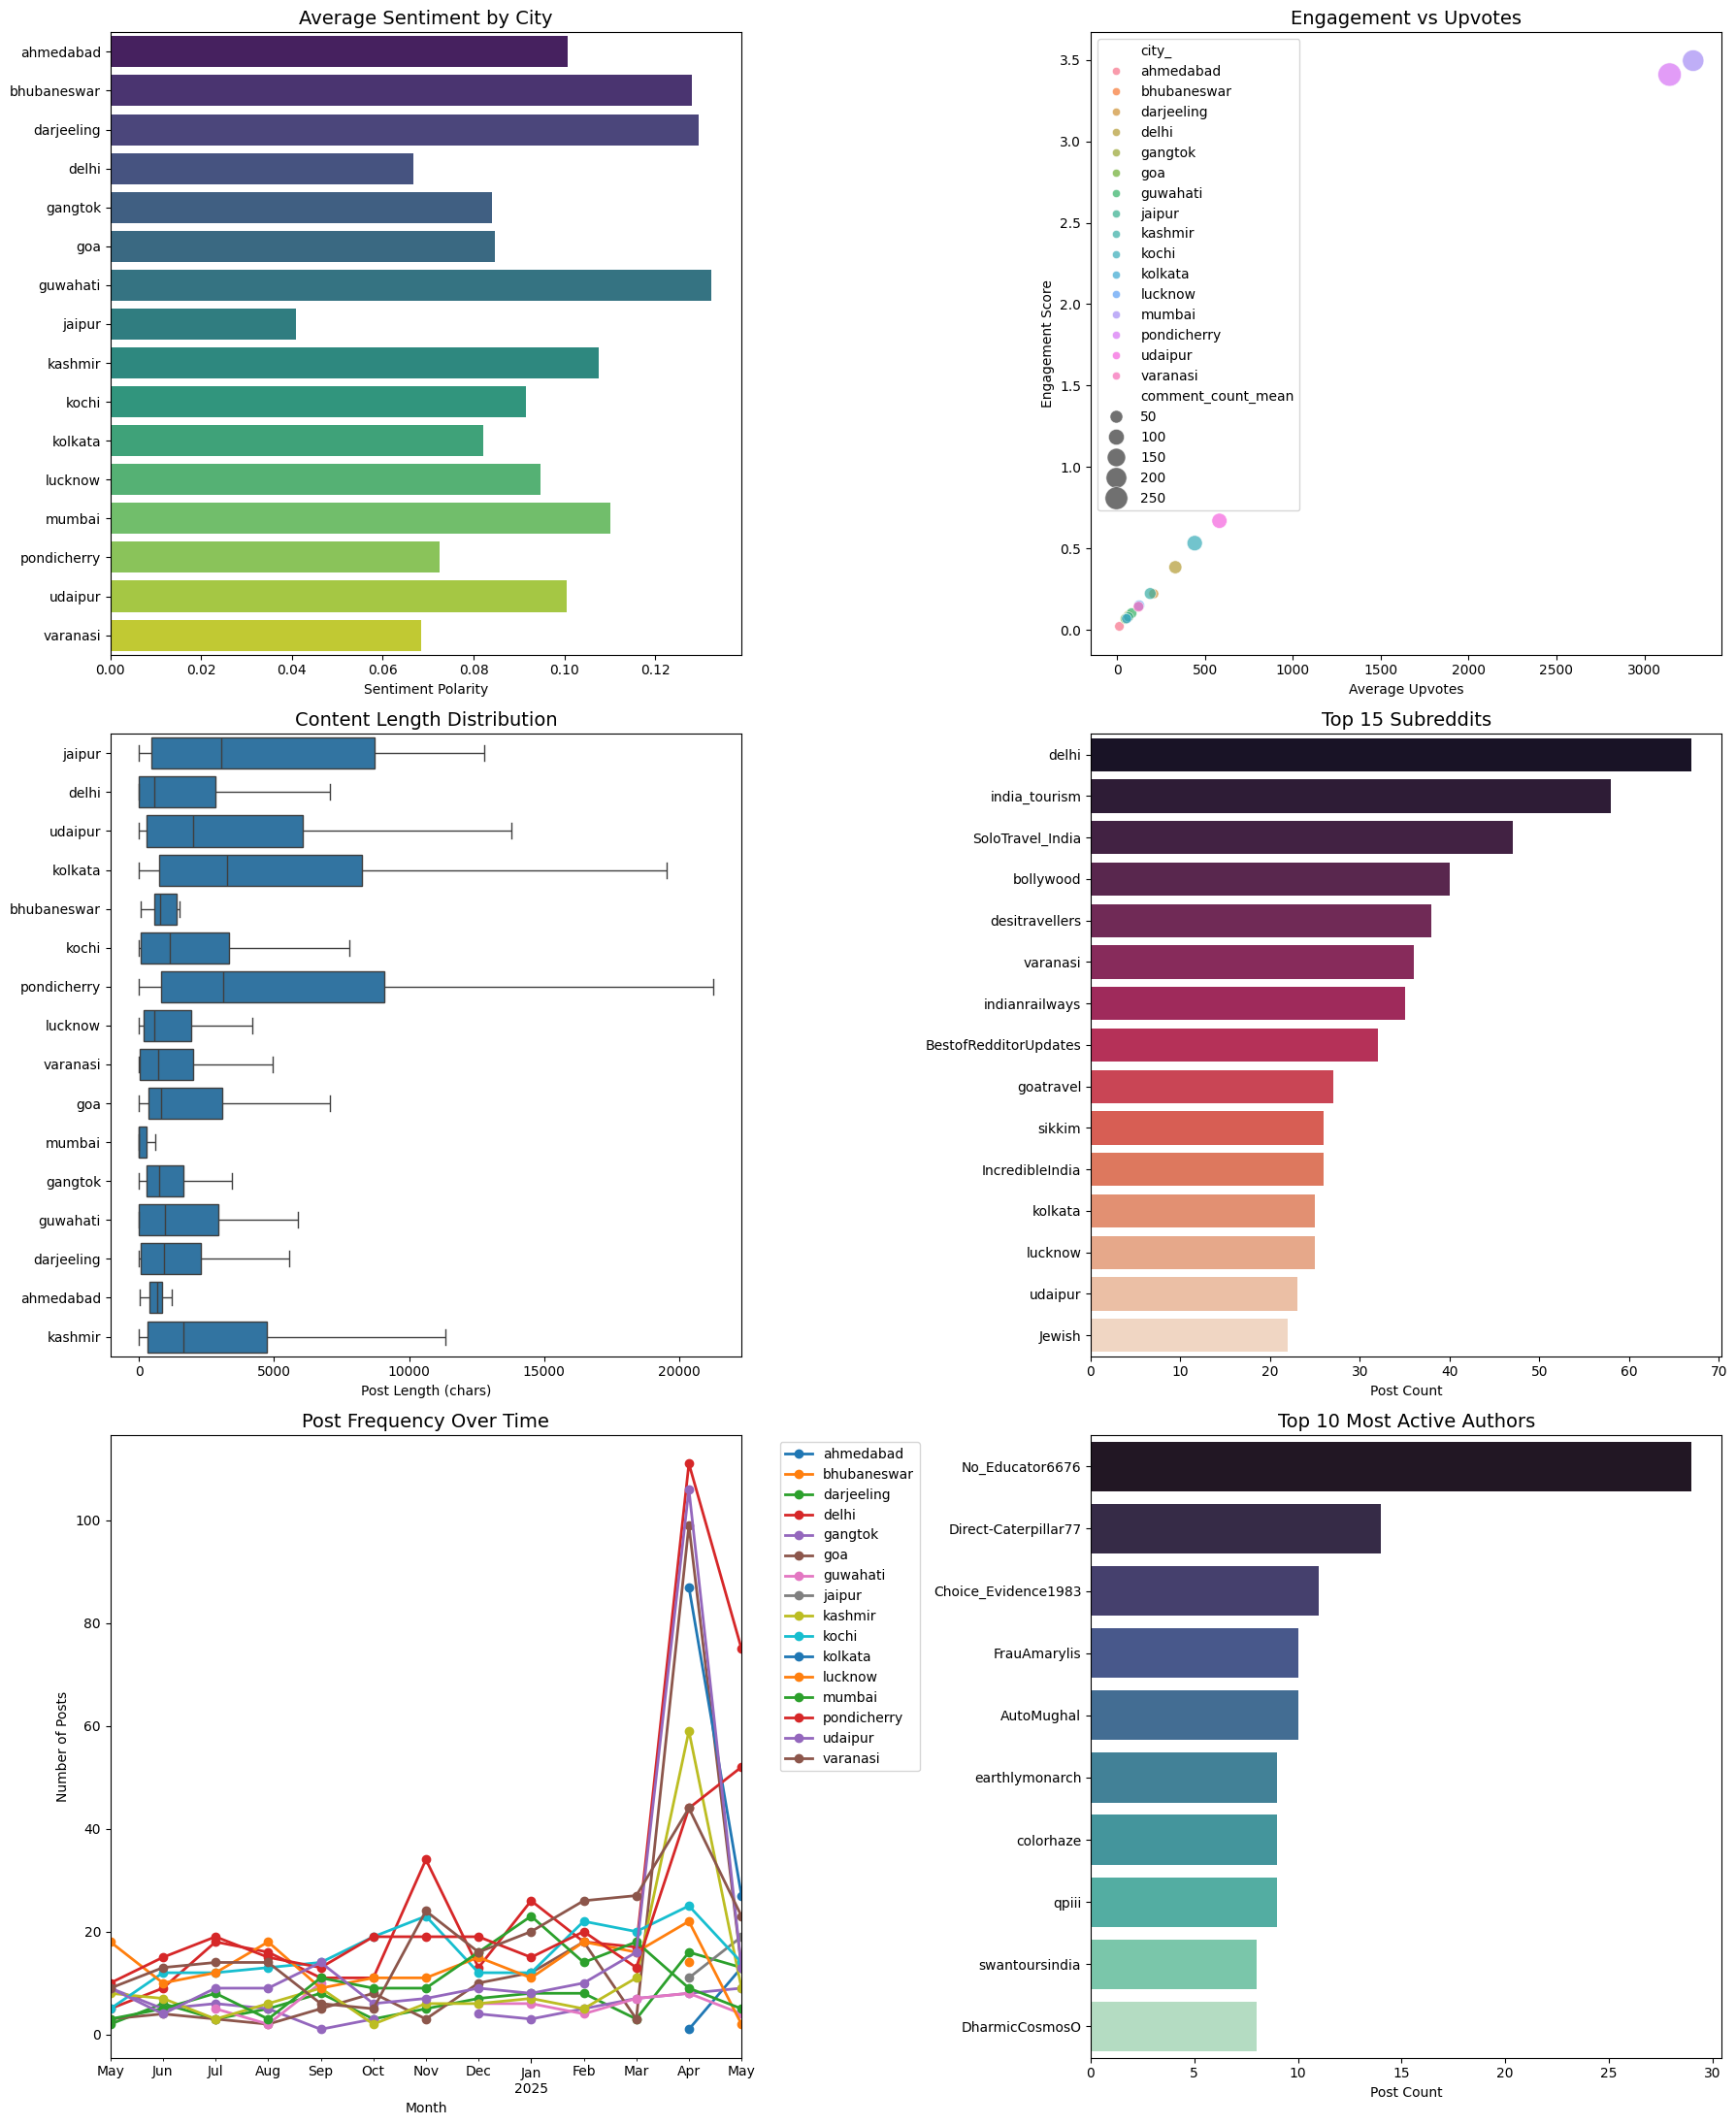


Performing topic modeling...

Discovered Topics:
Topic_0: india, tour, travel, city, visit
Topic_1: free, park, day, city, beach
Topic_2: like, just, time, don, people
Topic_3: https, com, www, https www, reddit
Topic_4: https, com, expedition, 33, expedition 33
Topic_5: https, png, auto, redd, width
Topic_6: india, war, world, new, people
Topic_7: imax, movie, 90, theatres, film

🎉 All tasks completed successfully!


In [ ]:
# ======================
# MAIN EXECUTION
# ======================
async def main():
    # Step 1: Scrape Data
    print("Starting data collection...")
    df = await scrape_reddit_posts()
    df.to_csv("reddit_travel_data_full.csv", index=False)
    print(f"\n✅ Collected {len(df)} total posts")

    # Step 2: Analyze Data
    print("\nAnalyzing data...")
    analysis = analyze_data(df)
    print(analysis.head())

    # Step 3: Visualize Results
    print("\nGenerating visualizations...")
    visualize_data(df, analysis)

    # Step 4: Topic Modeling
    print("\nPerforming topic modeling...")
    df, topics = perform_topic_modeling(df)
    print("\nDiscovered Topics:")
    for topic, words in topics.items():
        print(f"{topic}: {', '.join(words)}")

    # Save final results
    df.to_csv("reddit_travel_data_with_topics.csv", index=False)
    print("\n🎉 All tasks completed successfully!")

# Run in Colab
await main()